# DQN implementation in JAX

This notebook walks through an implementation of [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) in [JAX](https://jax.readthedocs.io/en/latest/).
There exists a complete [ecosystem](https://deepmind.com/blog/article/using-jax-to-accelerate-our-research) of libraries based on JAX to ease the developpement of deep and Reinforcement Learning algorithms, but because this notebook aims at demonstrating its core concepts, the implementation will only rely on "vanilla" JAX.

## JAX
From the official [quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) documentation:
> JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.

JAX is based on [XLA](https://www.tensorflow.org/xla) to provide a hardware accelerated backend to linear algebra operations, encapsulated in a NumPy-compatible API. To keep it simple, any numpy code can be replaced by its equivalent jax.numpy to be ported on GPU/TPU and run faster. 
Moreover, all these operations, as well as some native Python code, can be automatically differentiated, making JAX a good candidate to perform any kind of gradient based optimization.

JAX can be defined it as "an extensible system for composable function transformations".
The most useful transformations include:
* `grad`: Automatic differentiation transformation, `grad(func)` returns a function which is the gradient of `func`.
* `jit`: "Just in Time" compilation. Remember that each JAX array operation rely on a hardware accelerated backend ? Well, your code will most probably contains sequences of this operation, which would result in the backend being called sequentially to execute them. By compiling a sequence of operations, the backend could be called only once for the whole sequence, resulting in faster execution. 
* `vmap`: Automatic vectorisation transformation, can be used to easily apply operation to full batch instead of single elements.

All these transformations can be composed arbitrarily, you can take the gradient of a compiled vectorized funtcion for example: `grad(jit(vmap(f)))`. 
This transformation system may seem abstract for now, but the notebook contains example use case for each of them.

In [1]:
!pip install more_itertools

In [2]:
%matplotlib inline

from dataclasses import dataclass, field
from typing import NamedTuple, List, Tuple, Sequence, Callable
from functools import partial

import gym
from gym import logger
import numpy as np
import random as orandom
import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax
import jax.nn as nn
import matplotlib.pyplot as plt
import jax.experimental.optimizers as optimizers
from numpy.typing import ArrayLike
import more_itertools

SEED = 0
orandom.seed(SEED)
np.random.seed(SEED)

## Environment
The DQN agent will be train on the cartpole environment. See [here](https://gym.openai.com/envs/CartPole-v1/) for an explanation if you are unfamiliar with this environment.

![Cartpole](media/cartpole.jpg)

In [3]:
cartpole = gym.make("CartPole-v1")

## Experience Replay
Let's start by defining an experience replay buffer to store transitions. Transitions will be stored in a simple list, and will be converted to jax arrays only when needed for training, to avoid storing all the transitions on the GPU.

In [4]:
class Transition(NamedTuple):
    state: ArrayLike
    action: int
    reward: float
    next_state: ArrayLike
    done: bool

        
class ReplayBuffer:
    """Experience replay buffer."""
    def __init__(self, capacity: int):
        self.capacity: int = capacity
        self.data: List[Transition] = []
        self.index = 0 # index of the next element to insert in self.data
        
    def store(self, transition: Transition) -> None:
        """Store a transition."""
        if len(self.data) < self.capacity:
            self.data.append(transition)
        else:
            self.data[self.index] = transition
        self.index = (self.index + 1) % self.capacity
    
    def sample(self, batch_size: int) -> List[Transition]:
        """Sample a batch of transitions."""
        return orandom.sample(self.data, batch_size)

    def __len__(self):
        return len(self.data) 

## Model

Jax transformations (`jit`, `grad` and`vmap`) are designed to be used on functions that are functionnally pure. 
This means that all the input data of a function should be given as parameters, and all outputs should be returned by the function.
Additionally, any call to the function with the same parameters should return the same output.

Knowing this, it is not possible to define models similar to Tensorflow/Pytorch if we are to use compilation and differenciation. 
In those other frameworks, models are typically stateful objects, holding the weights as attributes. 
This is incompatible with the pure function definition, because weights are not given as parameters to function and are modified without being returned as outputs.
What is typically done in JAX is to pass weights as a parameter to a forward pass function.

Let's define a few components which would help defining a fully connected neural network.

Let's first define the structure of the NN. 
A layer will be a named tuple holding the weights and the biases, and a network will be a tuple of layers.
Note the use of immutable data structure: network parameters will not be modified in place, but a new set of parameters will be created after each optimization step, to stick to the pure function philosophy.

In [5]:
class FCLayerParams(NamedTuple):
    """Holds parameters of a fully connected layer."""
    weights: jnp.ndarray
    biases: jnp.ndarray

FCNetworkParams = Tuple[FCLayerParams]  # A network is a sequence of layers

Now let's define functions to initialize a network.

Note the use of `key` parameters. JAX deals with randomness differently from NumPy, to be more reproductible, parallelizable and vectorisable. More details can be found [here](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html?highlight=random#random-numbers-in-jax).

In [6]:
def init_layer_params(
    input_dim: int, output_dim: int, key: jnp.ndarray
) -> FCLayerParams:
    """Kaiming He initialisation of weights for a fully connected layer."""
    scale = np.sqrt(2. / input_dim) 
    weights = scale * random.normal(key, (output_dim, input_dim))
    biases = jnp.zeros(output_dim)
    return FCLayerParams(weights, biases)


def init_network_params(sizes: Sequence[int], key: jnp.ndarray) -> FCNetworkParams:
    """Initialize a fully connected network from layers sizes."""
    keys = random.split(key, len(sizes))
    return tuple(
        init_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)
    )

Now that we defined the structure and the initialization of a network, all is left to create is a forward function to predict the output of the network from the input.

Because this function will be used a lot of time, let's compile it with the `jit` decorator for faster execution.

In [7]:
@jit
def forward(params: FCNetworkParams, inputs: jnp.ndarray) -> jnp.ndarray:
    """Get the output of a fully connected network."""
    for layer in params:
        outputs = jnp.dot(layer.weights, inputs) + layer.biases
        inputs = nn.relu(outputs)
    return outputs

## Hyperparameters

Let's now define some hypereparameters for the training of our agent.

In [8]:
# Model
state_dim = cartpole.observation_space.shape[0]
action_size = cartpole.action_space.n
LAYER_SIZES = [state_dim, 32, 32, action_size]

# Optimizer
LEARNING_RATE = 0.001
BATCH_SIZE =  64 

# RLinput
GAMMA = 0.95
TAU = 0.01
BUFFER_SIZE = 1000000
EPSILON_MIN = 0.01
EPSILON_MAX = 1.0
EPSILON_DECAY = 0.995

## Usefull functions

In [9]:
Batch = Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]

def sample_minibatch(batch_size: int, replay_buffer: ReplayBuffer) -> Batch:
    """Sample transitions from replay buffer and convert it to a training batch."""
    transitions = replay_buffer.sample(batch_size)
    s, a, r, s_, d = zip(*transitions)
    return (
        jnp.vstack(s),
        jnp.asarray(a, dtype=jnp.int8),
        jnp.asarray(r, dtype=jnp.float32),
        jnp.vstack(s_),
        jnp.asarray(d, dtype=jnp.float32),
    )


@jit
def greedy_action(params: FCNetworkParams, state: jnp.ndarray) -> jnp.ndarray:
    """Compute greedy action w.r.t to network parameters."""
    Q = forward(params, state)
    return jnp.argmax(Q)


def epsilon_greedy(env, epsilon, params, state):
    """Compute an epsilon greey action"""
    if np.random.rand() < epsilon:
        action = env.action_space.sample()
    else:
        action = int(greedy_action(params, state))
    return action

def td_error(
    params: FCNetworkParams,
    target_params: FCNetworkParams,
    s: jnp.ndarray,
    a: int,
    r: float,
    s_: jnp.ndarray,
    d: float,
) -> float:
    """Compute the TD error for one sampled transition."""
    target_Q = jnp.max(forward(target_params, s_))
    target = r + GAMMA * (1 - d) * jax.lax.stop_gradient(target_Q)
    Q = forward(params, s)[a]
    return target - Q


def loss(params: FCNetworkParams, target_params: FCNetworkParams, batch: Batch):
    """Compute the loss on a batch."""
    # Vectorized version of the td_error function
    batched_td_errors = vmap(partial(td_error, params, target_params), in_axes=[0] * 5)
    # Apply this function to batch
    td_errors_values = batched_td_errors(*batch)
    return jnp.mean(jnp.square(td_errors_values))

grad_loss = jit(grad(loss, argnums=0))

def actor_learning_step(
    opt_update: Callable,
    opt_state: optimizers.OptimizerState,
    params: FCNetworkParams,
    target_params: FCNetworkParams,
    step: int,
    batch: Batch,
) -> optimizers.OptimizerState:
    """Run a step of learning for the actor."""
    grads = grad_loss(params, target_params, batch)
    grads = optimizers.clip_grads(grads, 1)
    return opt_update(step, grads, opt_state)


# TODO tree_multimap explanation and static param tau
@jit
def soft_update(
    params: FCNetworkParams, target_params: FCNetworkParams, tau: float
) -> FCNetworkParams:
    """Update the target parameters towards actor's with momentum tau."""
    return jax.tree_multimap(
        lambda p, target_p: tau * p + (1 - tau) * target_p,
        params,
        target_params,
    )

In [10]:
def train(env: gym.Env, max_episode: int):
    """Train a DQN neural network on env for max_episode."""
    # Initialize parameters
    params = init_network_params(LAYER_SIZES, random.PRNGKey(SEED))
    target_params = params

    # Initialize optimizer
    opt_init, opt_update, get_params = optimizers.adam(LEARNING_RATE)
    opt_state = opt_init(params)

    memory = ReplayBuffer(BUFFER_SIZE)

    # jit compile the actor learning step
    _actor_step = jit(partial(actor_learning_step, opt_update))
    _sample_minibatch = partial(sample_minibatch, BATCH_SIZE)

    # Initialize metrics variables
    scores = [0] * max_episode
    state = env.reset()
    done = False
    epsilon = EPSILON_MAX
    opt_step = 0

    for episode in range(max_episode):
        while not done:
            action = epsilon_greedy(env, epsilon, params, state)

            # Environment step
            next_state, reward, done, _ = env.step(action)
            memory.store(Transition(state, action, reward, next_state, done))
            scores[episode] += reward

            # Training step
            if len(memory) > BATCH_SIZE:
                opt_step += 1
                batch = _sample_minibatch(memory)
                opt_state = _actor_step(opt_state, params, target_params, opt_step, batch)
                params = get_params(opt_state)

                target_params = soft_update(params, target_params, TAU)
                epsilon = max(epsilon * EPSILON_DECAY, EPSILON_MIN)

            state = next_state

        if episode % 10 == 0:
            print(
                f"Episode {episode}",
                f", epsilon {epsilon:.2f}",
                f", episode return {scores[episode]:.1f}",
                sep="",
            )
        state = env.reset()
        done = False

    return scores, params

In [11]:
scores, params = train(cartpole, 120)

Episode 0, epsilon 1.00, episode return 13.0
Episode 10, epsilon 0.45, episode return 15.0
Episode 20, epsilon 0.26, episode return 13.0
Episode 30, epsilon 0.16, episode return 13.0
Episode 40, epsilon 0.09, episode return 14.0
Episode 50, epsilon 0.06, episode return 10.0
Episode 60, epsilon 0.01, episode return 76.0
Episode 70, epsilon 0.01, episode return 141.0
Episode 80, epsilon 0.01, episode return 238.0
Episode 90, epsilon 0.01, episode return 229.0
Episode 100, epsilon 0.01, episode return 179.0
Episode 110, epsilon 0.01, episode return 228.0


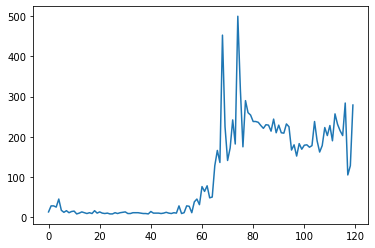

In [12]:
plt.plot(scores)
plt.show()

In [13]:
def rollout(params: FCNetworkParams, env: gym.Env, render:bool = False):
    s = env.reset()
    d = False
    score = 0
    if render:
        env.render()
    while not d:
        s, r, d, _ = env.step(int(greedy_action(params, s)))
        score += r
        if render:
            env.render()
    return score

rollout(params, cartpole, render=True)

157.0

In [14]:
def evaluate(params: FCNetworkParams, env: gym.Env, n_episodes:int = 100):
    scores = []
    for _ in range(100):
        scores.append(rollout(params, cartpole))
    return np.mean(scores)

evaluate(params, cartpole)

171.74